In [5]:
import numpy as np 
import matplotlib.pyplot as plt

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

Load the Data

In [7]:
transform = transforms.ToTensor()
train_set = datasets.MNIST(root='data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)

Visualize the Data

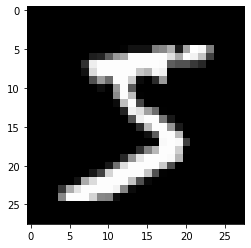

In [8]:
data = iter(train_loader)
images, labels = data.next()
plt.imshow(images[0].squeeze(), cmap='gray');

**Discriminator Architecture**

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size*4)
        self.fc2 = nn.Linear(hidden_size*4, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size)

        self.fc4 = nn.Linear(hidden_size, output_size)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        x = torch.sigmoid(self.fc4(x))

        return x


**Generator Architecture**

In [10]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size*4)

        self.fc4 = nn.Linear(hidden_size*4, output_size)
        self.dropout = nn.Dropout(p=0.3)
  
    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        x = torch.tanh(self.fc4(x))
        
        return x

**Model Hyperparameters**

In [11]:
# Discriminator

input_size = 784
d_hidden_size = 32
d_output_size = 1

# Generatoe

z_size = 100
g_hidden_size = 32
g_output_size = 784


G = Generator(z_size, g_hidden_size, g_output_size)
D = Discriminator(input_size, d_hidden_size, d_output_size)

print(G)
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


**Loss and Optimizer**

In [47]:
def real_loss(d_out):
    batch_size = d_out.size(0)

    labels = torch.ones(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(d_out.squeeze(), labels)

    return loss

def fake_loss(d_out):
    batch_size = d_out.size(0)

    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(d_out.squeeze(), labels)

    return loss


d_optimizer = torch.optim.Adam(D.parameters(), lr=0.001)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.001)

**Train the model**


Discriminator training


*   Compute the discriminator loss on real, training images
*   Generate fake images
*   Compute the discriminator loss on fake, generated images
*  Add real loss and fake loss
*  perform back prop and optimization step to update discriminator weights

Generator training


*   Generate fake images
*   Compute the discriminator loss on fake images, using flipped labels!
*   Perform backpropagation + an optimization step to update the generator's weights


In [49]:
epochs = 10 
samples = []
fixed_z = torch.from_numpy(np.random.uniform(-1, 1, size=(16, z_size))).float()
for epoch in range(epochs):
    for batch, (images, _) in enumerate(train_loader):

        batch_size = images.size(0)
        images = images*2 - 1 # resize images from the scale [0, 1] to [-1, 1]

        ## Train the Discriminator
        ## Compute real loss
        d_optimizer.zero_grad()
        d_real = D(images)
        d_real_loss = real_loss(d_real)
        ## Generate Fake Images 
        z = np.random.uniform(-1, 1, size = (batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        ## Compute loss on fake images
        d_fake = D(fake_images)
        d_fake_loss = fake_loss(d_fake)

        # Add real loss and fake loss
        d_loss = d_real_loss + d_fake_loss

        # back prop and optimization step
        d_loss.backward()
        d_optimizer.step()


        ### Train the Generator

        g_optimizer.zero_grad()

        ## Generate Fake Images
        z = np.random.uniform(-1, 1, (batch_size, z_size))
        z = torch.from_numpy(z).float()

        fake_images = G(z)

        d_fake = D(fake_images)
        g_loss = real_loss(d_fake)

        g_loss.backward()
        g_optimizer.step()

    print("Epoch {}  Generator Loss {} Discriminator Loss {}".format(epoch+1, g_loss.item(), d_loss.item()))
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() 


Epoch 1  Generator Loss 0.6931471824645996 Discriminator Loss 1.3862943649291992
Epoch 2  Generator Loss 0.6931471824645996 Discriminator Loss 1.3862943649291992
Epoch 3  Generator Loss 0.6931471824645996 Discriminator Loss 1.3862943649291992
Epoch 4  Generator Loss 0.6931471824645996 Discriminator Loss 1.3862943649291992
Epoch 5  Generator Loss 0.6931471824645996 Discriminator Loss 1.3862943649291992
Epoch 6  Generator Loss 0.6931471824645996 Discriminator Loss 1.3862943649291992
Epoch 7  Generator Loss 0.6931471824645996 Discriminator Loss 1.3862943649291992
Epoch 8  Generator Loss 0.6931471824645996 Discriminator Loss 1.3862943649291992
Epoch 9  Generator Loss 0.6931471824645996 Discriminator Loss 1.3862943649291992
Epoch 10  Generator Loss 0.6931471824645996 Discriminator Loss 1.3862943649291992


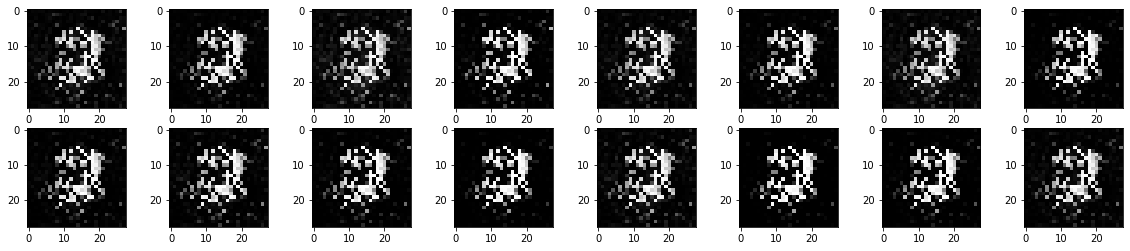

In [71]:
sample_images = samples[-1]
sample_images = sample_images.detach().numpy()
plt.figure(figsize=(20,4))
for i in range(16):
    ax = plt.subplot(2, 8, i+1)
    ax.imshow(sample_images[i].reshape(28, 28), cmap='gray')

In [1]:
## Changing Relu to Leaky Relu
## Adding Smooth parameter ie 0.9 as true label instead of 1
## Running more number of epochs can help model to learn better and generate better samples